## 10.1

In [12]:
from datasets import load_dataset
dataset = load_dataset("id_nergrit_corpus", "ner", trust_remote_code=True)

In [13]:
# Melihat contoh data dari split 'train'
print(dataset['train'][1])

# Menampilkan struktur dataset
print(dataset)

{'id': '1', 'tokens': ['Martahan', 'Sohuturon', ',', 'CNN', 'Indonesia', '|', 'Rabu', ',', '16', '/', '05', '/', '2018', '08', ':', '20', 'WIB'], 'ner_tags': [12, 31, 38, 11, 30, 38, 1, 20, 20, 20, 20, 20, 20, 17, 36, 36, 36]}
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 12532
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2399
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2521
    })
})


In [14]:
# Memanggil label entitas pada dataset
label_mapping = dataset['train'].features['ner_tags'].feature.names

# Menampilkan label entitas
print(label_mapping)

['B-CRD', 'B-DAT', 'B-EVT', 'B-FAC', 'B-GPE', 'B-LAN', 'B-LAW', 'B-LOC', 'B-MON', 'B-NOR', 'B-ORD', 'B-ORG', 'B-PER', 'B-PRC', 'B-PRD', 'B-QTY', 'B-REG', 'B-TIM', 'B-WOA', 'I-CRD', 'I-DAT', 'I-EVT', 'I-FAC', 'I-GPE', 'I-LAN', 'I-LAW', 'I-LOC', 'I-MON', 'I-NOR', 'I-ORD', 'I-ORG', 'I-PER', 'I-PRC', 'I-PRD', 'I-QTY', 'I-REG', 'I-TIM', 'I-WOA', 'O']


In [15]:
# Memanggil label entitas pada dataset
label_mapping = dataset['train'].features['ner_tags'].feature.names

# Membuat dictionary yang memetakan ID ke label entitas
id2label = {i: label for i, label in enumerate(label_mapping)}

# Menampilkan ID pada setiap label entitas
print(id2label)

{0: 'B-CRD', 1: 'B-DAT', 2: 'B-EVT', 3: 'B-FAC', 4: 'B-GPE', 5: 'B-LAN', 6: 'B-LAW', 7: 'B-LOC', 8: 'B-MON', 9: 'B-NOR', 10: 'B-ORD', 11: 'B-ORG', 12: 'B-PER', 13: 'B-PRC', 14: 'B-PRD', 15: 'B-QTY', 16: 'B-REG', 17: 'B-TIM', 18: 'B-WOA', 19: 'I-CRD', 20: 'I-DAT', 21: 'I-EVT', 22: 'I-FAC', 23: 'I-GPE', 24: 'I-LAN', 25: 'I-LAW', 26: 'I-LOC', 27: 'I-MON', 28: 'I-NOR', 29: 'I-ORD', 30: 'I-ORG', 31: 'I-PER', 32: 'I-PRC', 33: 'I-PRD', 34: 'I-QTY', 35: 'I-REG', 36: 'I-TIM', 37: 'I-WOA', 38: 'O'}


In [16]:
dataset.save_to_disk("negrit_corpus_local")

Saving the dataset (0/1 shards):   0%|          | 0/12532 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2399 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2521 [00:00<?, ? examples/s]

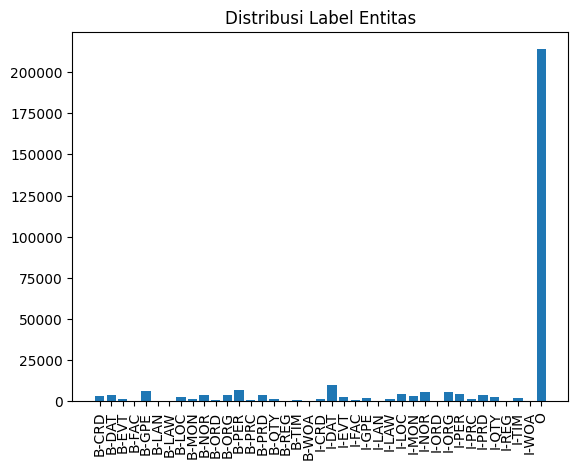

In [17]:
# Memanggil pustaka yang dibutuhkan
from collections import Counter
import matplotlib.pyplot as plt

# Menghitung distribusi label
labels = [label for example in dataset['train'] for label in example['ner_tags']]
label_counts = Counter(labels)

# Visualisasi
plt.bar(label_mapping, [label_counts[i] for i in
range(len(label_mapping))])
plt.title("Distribusi Label Entitas")
plt.xticks(rotation=90)
plt.show()

## 10.2

In [18]:
# Mengimpor pustaka
from datasets import Sequence, ClassLabel

# Definisikan nama label baru untuk fokus pada entitas lokasi
label_new = ['O', 'B-LOC', 'I-LOC']

# Mengubah kolom 'ner_tags' agar hanya mencakup label yang relevan 
dataset = dataset.cast_column("ner_tags", Sequence(ClassLabel(names= label_new)))

# Membuat peta id-to-label dan label-to-id untuk pemetaan label
id2label = {i: label for i, label in enumerate(label_new)}
label2id = {v: k for k, v in id2label.items()}

# Menampilkan peta id-to-label
print(id2label)

{0: 'O', 1: 'B-LOC', 2: 'I-LOC'}


In [19]:
# Definisi label baru untuk memetakan ulang entitas
label_new = {
    7: 1, # B-LOC
    26: 2, # I-LOC
    4: 1, # B-GPE => B-LOC
    23: 2, # I-GPE => I-LOC
    38: 0, # O (other)
}

# Fungsi untuk normalisasi tag entitas
def normalization_ner_tags(data, dict=None):
    ner_tags = []  # Untuk menyimpan tag baru
    ner_tokens = []  # Untuk menyimpan token yang relevan
    
    # Iterate over the data
    for tags, tokens in zip(data['ner_tags'], data['tokens']):
        tag_list, token_list = [], []
        for tag, token in zip(tags, tokens):
            # Jika tag ada dalam kamus, ganti dengan nilai baru
            if tag in [*dict][:-1]:
                tag_list.append(dict[tag])
                token_list.append(token)
            else:
                # Jika tidak relevan, tandai sebagai nol (0)
                tag_list.append(0)
                token_list.append(token)
        
        ner_tags.append(tag_list)
        ner_tokens.append(token_list)

    # Return the entire processed dataset after the loop
    return { 'tokens': ner_tokens, 'ner_tags': ner_tags }

    
# Memetakan ulang dataset menggunakan fungsi normalisasi
dataset = dataset.map(lambda data: normalization_ner_tags(data, dict=label_new), batched=True)

In [20]:
# Memfilter data untuk menyimpan hanya data dengan tag lokasi
dataset = dataset.filter(lambda data: any(tag in
[*label_new.values()][:-1] for tag in data['ner_tags']))

# Menampilkan data setelah pembersihan
print(dataset['train'][1])

Filter:   0%|          | 0/12532 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2399 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2521 [00:00<?, ? examples/s]

{'id': '3', 'tokens': ['Jakarta', ',', 'CNN', 'Indonesia', '--', 'Kepolisian', 'Negara', 'Republik', 'Indonesia', '(', 'Polri', ')', 'menyatakan', 'mulai', 'mengawasi', 'peredaran', 'berbagai', 'komponen', 'bahan', 'peledak', 'triacetone', 'triperoxide', '(', 'TATP', ')', '.', 'Zat', 'itu', 'kerap', 'digunakan', 'buat', 'meracik', 'bom', 'berdaya', 'ledak', 'tinggi', ',', 'seperti', 'yang', 'dipakai', 'di', 'dalam', 'serangan', 'teroris', 'di', 'Surabaya', 'pada', '13', 'Mei', 'dan', 'Senin', 'lalu', '.'], 'ner_tags': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}


In [22]:
# Memanggil pustaka transformers
from transformers import AutoTokenizer

# Memuat tokenizer untuk model XLM-RoBERTa
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Menerapkan tokenizer pada data contoh dari dataset
inputs = tokenizer(dataset["train"][1]["tokens"],
is_split_into_words=True)

# Menampilkan hasil tokenisasi
print(inputs.tokens())

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

['<s>', '▁Jakarta', '▁', ',', '▁CNN', '▁Indonesia', '▁--', '▁Ke', 'polis', 'ian', '▁Negara', '▁Republik', '▁Indonesia', '▁(', '▁Pol', 'ri', '▁)', '▁menyatakan', '▁mulai', '▁menga', 'wa', 'si', '▁pere', 'daran', '▁berbagai', '▁komponen', '▁bahan', '▁pele', 'dak', '▁tri', 'ace', 'tone', '▁trip', 'er', 'oxid', 'e', '▁(', '▁TA', 'TP', '▁)', '▁', '.', '▁Za', 't', '▁itu', '▁kerap', '▁digunakan', '▁buat', '▁mera', 'cik', '▁bom', '▁ber', 'daya', '▁le', 'dak', '▁tinggi', '▁', ',', '▁seperti', '▁yang', '▁dipakai', '▁di', '▁dalam', '▁serangan', '▁teroris', '▁di', '▁Surabaya', '▁pada', '▁13', '▁Mei', '▁dan', '▁Senin', '▁lalu', '▁', '.', '</s>']


In [23]:
# Fungsi untuk tokenisasi data
def tokenize_and_align_labels(data):
    tokenized_inputs = tokenizer(data["tokens"], truncation=True, is_split_into_words=True)

    # Menyesuaikan label dengan token hasil tokenisasi
    labels = []
    for i, label in enumerate(data["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100) # Label token khusus (misalnya <PAD>)
            elif word_idx != previous_word_idx:
                aligned_labels.append(label[word_idx])
            else:
                aligned_labels.append(-100) # Token tambahan dalam subword
                previous_word_idx = word_idx
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [24]:
# Tokenisasi dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset["train"].column_names)

# Menampilkan hasil tokenizer
print(tokenized_dataset['train'][1])

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/853 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

{'input_ids': [0, 18218, 6, 4, 75533, 3799, 4210, 1345, 34740, 3378, 20698, 39460, 3799, 15, 9017, 416, 1388, 37812, 13166, 14169, 634, 172, 21440, 74698, 13878, 87224, 12034, 28030, 22367, 1927, 8509, 40491, 24745, 56, 61942, 13, 15, 12998, 23658, 1388, 6, 5, 825, 18, 752, 113549, 10815, 5297, 13057, 15903, 8634, 770, 44963, 95, 22367, 9536, 6, 4, 2585, 119, 74547, 45, 638, 81401, 145576, 45, 84597, 843, 702, 11204, 123, 96339, 5441, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -100]}


In [25]:
from transformers import DataCollatorForTokenClassification

# Data collator untuk tugas token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

2025-01-03 17:51:50.741673: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 17:51:50.744103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 17:51:50.752030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735901510.764446   60927 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735901510.767962   60927 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 17:51:50.779926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 10.3

In [26]:
# Menginstal pustaka seqeval dan evaluate
! pip install seqeval
! pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=e1b905d86ba1c35ff142d433f1e3d1b9be111ed99ecb7947aac40138930aee40
  Stored in directory: /home/fajarshiddiqqq/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
from seqeval.metrics import accuracy_score, classification_report
import evaluate
import numpy as np

# Memuat evaluator untuk seqeval
metric = evaluate.load("seqeval")

# Fungsi untuk menghitung metrik evaluasi
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    # Menghapus token khusus dan mengonversi ke label
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [[label_names[p] for (p, l) in zip(prediction, label) if l !=-100] for prediction, label in zip(predictions, labels)]
    
    # Menampilkan laporan klasifikasi
    print(classification_report(true_labels, true_predictions))
    print('accuracy\t', accuracy_score(true_labels, true_predictions))
    
    # Menghitung metrik lainnya
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [29]:
from transformers import AutoModelForTokenClassification

# Memuat model XLM-RoBERTa untuk tugas token classification
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base", # Nama model
    id2label=id2label,
    label2id=label2id,
    num_labels=len(label_names) # Jumlah label untuk klasifikasi
)

ImportError: 
AutoModelForTokenClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForTokenClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [ ]:
from torchinfo import summary

print(summary(model))

In [30]:
from transformers import TrainingArguments

# Menentukan parameter pelatihan
training_args = TrainingArguments(
    output_dir="./model", # Direktori untuk menyimpan hasil pelatihan
    evaluation_strategy="epoch", # Evaluasi di akhir setiap epoch
    learning_rate=2e-5, # Learning rate
    per_device_train_batch_size=16, # Ukuran batch untuk pelatihan
    per_device_eval_batch_size=16, # Ukuran batch untuk evaluasi
    num_train_epochs=3, # Jumlah epoch pelatihan
    weight_decay=0.01, # Regulasi weight decay
    logging_dir="./logs", # Direktori untuk menyimpan log pelatihan
)

/home/fajarshiddiqqq/miniconda3/envs/bukusilvanus/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


RuntimeError: Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
from transformers import Trainer

# Membuat Trainer untuk pelatihan model
trainer = Trainer(
    model=model, # Model yang dilatih
    args=training_args, # Argumen pelatihan
    train_dataset=tokenized_dataset["train"], # Dataset pelatihan
    eval_dataset=tokenized_dataset["validation"], # Dataset evaluasi
    tokenizer=tokenizer, # Tokenizer untuk model
    data_collator=data_collator, # Data collator untuk batching
    compute_metrics=compute_metrics, # Fungsi untuk metrik evaluasi
)

# Melatih model
trainer.train()

In [ ]:
# Melakukan prediksi pada data uji
predictions = trainer.predict(tokenized_dataset["test"])

In [ ]:
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

# Mengatur geolocator menggunakan Nominatim dengan user-agent untuk mengidentifikasi aplikasi
geolocator = Nominatim(user_agent="peta_teks_spasial")

In [ ]:
# Mengimpor pipeline dari Hugging Face untuk memproses Named Entity Recognition (NER)
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

# Memuat tokenizer yang sesuai dengan model NER
tokenizer = AutoTokenizer.from_pretrained("model")

# Memuat model NER yang telah dilatih
model = AutoModelForTokenClassification.from_pretrained("model")

# Membuat pipeline NER untuk melakukan prediksi
ner = pipeline(
    "ner", # Tugas yang dilakukan adalah Named Entity Recognition
    model=model, # Model NER yang telah dimuat
    tokenizer=tokenizer, # Tokenizer yang sesuai dengan model
    grouped_entities=True # Mengelompokkan entitas serupa (seperti lokasi yang terdiri dari beberapa kata)
)

In [ ]:
# Daftar teks yang akan dianalisis
tweets = [
 "Kebakaran hutan dan lahan terus terjadi dan semakin meluas di Kota Palangkaraya, Kalimantan Tengah (Kalteng) pada Senin, 15 Nopember 2023 08.00 WIB. Bahkan kobaran api mulai membakar pondok warga dan mendekati permukiman. BZK #RCTINews #SeputariNews #News #Karhutla #KebakaranHutan #HutanKalimantan #SILVANUS_Italian_Pilot_Testing"
]

# List untuk menyimpan hasil lokasi
location = []

# Melakukan prediksi NER pada setiap tweet
for results in ner(tweets):
    # Menyimpan entitas lokasi (LOC) yang terdeteksi dalam teks
    location.append(', '.join([t['word'] for t in results if t['entity_group'] == 'LOC']))

In [ ]:
# Mengonversi nama lokasi menjadi koordinat geografis menggunakan Nominatim
locations = [geolocator.geocode(loc) for loc in location if loc is not None]

In [ ]:
# Membuat peta awal dengan lokasi pusat pada latitude dan longitude tertentu
geocoded_map = folium.Map(location=[20, 0], zoom_start=2)

# Menambahkan fitur MarkerCluster untuk mengelompokkan marker
marker_cluster = MarkerCluster().add_to(geocoded_map)

# Menambahkan marker untuk setiap lokasi pada peta
for i, loc in enumerate(locations):
    # Menambahkan marker ke dalam marker cluster
    folium.Marker(
        location=[loc.latitude, loc.longitude], # Lokasi geografis dari geocoding
        popup=tweets[i], # Menampilkan teks tweet saat marker diklik
        tooltip=location[i], # Tooltip lokasi nama
        icon=folium.Icon(color='red', prefix='glyphicon', icon='fire'), # Ikon marker
        clustered_marker=True
    ).add_to(marker_cluster)

# Menampilkan peta interaktif
display(geocoded_map)